In [1]:
# Tampilkan versi python dan tensorflow yang digunakan
import sys
print("Versi Python:", sys.version)

# Menampilkan versi TensorFlow
import tensorflow as tf


Versi Python: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]


2024-04-04 14:45:57.264833: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 14:45:57.264930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 14:45:57.427164: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Instal Semua Library Yang Diperlukan
import os
from skimage import io
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.applications.inception_v3 import *

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score

In [3]:
target = 299
dataPath = '/kaggle/input/glaucoma-dataset-eyepacs-airogs-light-v2/eyepac-light-v2-512-jpg/'

trainDataGen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    horizontal_flip=True, 
    vertical_flip=True, 
    brightness_range=(0.9, 1.1)
)
trainGen = trainDataGen.flow_from_directory(
    shuffle=True,  
    class_mode="binary", 
    target_size=(target, target), 
    directory=dataPath + 'train', 
    color_mode='rgb')

valDataGen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
valGen = valDataGen.flow_from_directory(
    class_mode="binary", 
    target_size=(target, target), 
    directory=dataPath + 'validation', 
    shuffle=False,
    color_mode='rgb'
)

testDataGen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
testGen = testDataGen.flow_from_directory(
    batch_size = 1, 
    class_mode="binary", 
    target_size=(target, target), 
    directory=dataPath + 'test', 
    shuffle=False,
    color_mode='rgb'
)

Found 8000 images belonging to 2 classes.
Found 770 images belonging to 2 classes.
Found 770 images belonging to 2 classes.


In [4]:
baseModel = InceptionV3(input_shape = (299, 299, 3),
                                  include_top = False,
                                  weights = 'imagenet')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Cari nama layer terakhir dari inception v3
lastLayerName = baseModel.layers[-1].name

# Output of the last layer in InceptionV3
x = baseModel.output
x = layers.Flatten()(x)

# Output layer untuk binary classification (activation= sigmoid)
output_tensor = Dense(1, activation='sigmoid')(x)

# Create the new model by combining the InceptionV3 base model and the additional layers
model = Model(inputs=baseModel.input, outputs=output_tensor)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,933,857 (83.67 MB)

 Trainable params: 21,899,425 (83.54 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [6]:
# Definisikan Hyperparameter yang digunakan
batch_size = 32
learning_rate = 0.0001
epoch = 20

optimizer= keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy', 
    metrics=['binary_accuracy',
             keras.metrics.AUC(),
             keras.metrics.Precision(), 
             keras.metrics.Recall()])

history = model.fit(
    trainGen, 
    batch_size = batch_size,
    validation_data=valGen, 
    epochs=epoch,
    verbose=1
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1712242098.685637      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - auc: 0.7716 - binary_accuracy: 0.6995 - loss: 0.6055 - precision: 0.6996 - recall: 0.6967 - val_auc: 0.9313 - val_binary_accuracy: 0.8377 - val_loss: 0.4339 - val_precision: 0.9221 - val_recall: 0.7377
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 221s 861ms/step - auc: 0.9355 - binary_accuracy: 0.8610 - loss: 0.3233 - precision: 0.8595 - recall: 0.8607 - val_auc: 0.9631 - val_binary_accuracy: 0.9000 - val_loss: 0.2679 - val_precision: 0.8581 - val_recall: 0.9584
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 221s 860ms/step - auc: 0.9574 - binary_accuracy: 0.8916 - loss: 0.2649 - precision: 0.8824 - recall: 0.8983 - val_auc: 0.9739 - val_binary_accuracy: 0.8961 - val_loss: 0.2511 - val_precision: 0.9580 - val_recall: 0.8286
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 224s 870ms/step - auc: 0.9620 - binary_accuracy: 0.9003 - loss: 0.2502 - precision: 0.8968 - recall: 0.9068 - val_auc: 0.9769 - val_binary_accuracy: 0.9286 - val_loss: 0.1899 - val_precision: 0.

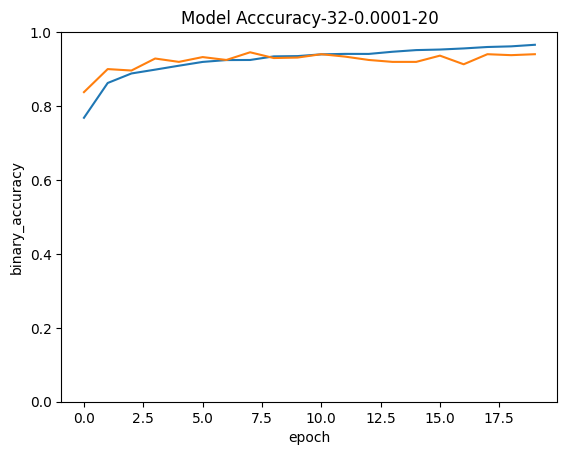

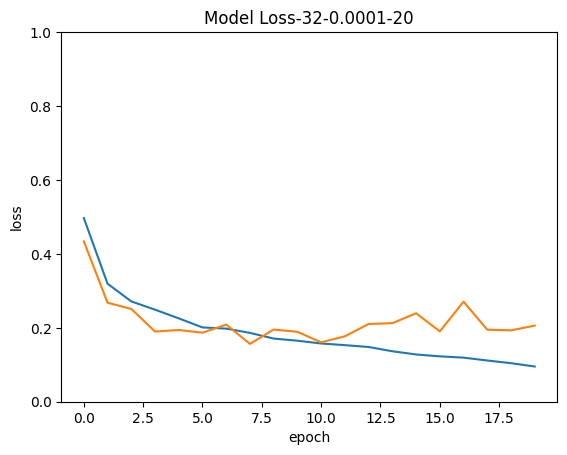

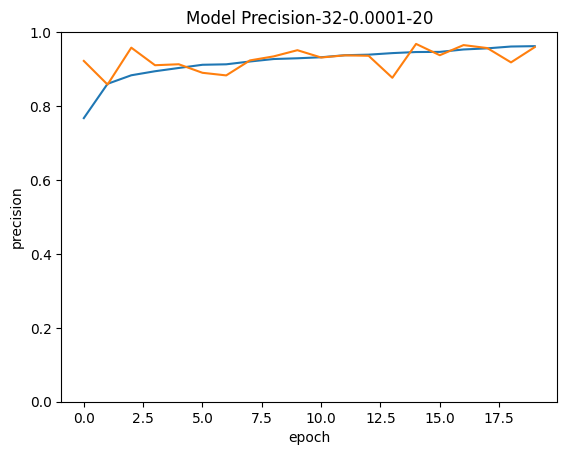

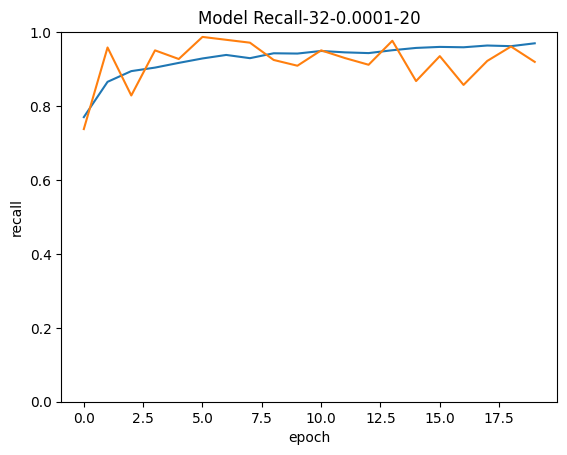

In [7]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title(f'Model Acccuracy-{batch_size}-{learning_rate}-{epoch}')
plt.ylabel("binary_accuracy")
plt.xlabel("epoch")
plt.ylim(0, 1)
plt.savefig(f'binaryAcccuracy-{batch_size}-{learning_rate}-{epoch}.png')
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title(f'Model Loss-{batch_size}-{learning_rate}-{epoch}')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.ylim(0, 1)
plt.savefig(f'loss-{batch_size}-{learning_rate}-{epoch}.png')
plt.show()

plt.plot(history.history["precision"])
plt.plot(history.history["val_precision"])
plt.title(f'Model Precision-{batch_size}-{learning_rate}-{epoch}')
plt.ylabel("precision")
plt.xlabel("epoch")
plt.ylim(0, 1)
plt.savefig(f'precision-{batch_size}-{learning_rate}-{epoch}.png')
plt.show()

plt.plot(history.history["recall"])
plt.plot(history.history["val_recall"])
plt.title(f'Model Recall-{batch_size}-{learning_rate}-{epoch}')
plt.ylabel("recall")
plt.xlabel("epoch")
plt.ylim(0, 1)
plt.savefig(f'recall-{batch_size}-{learning_rate}-{epoch}.png')
plt.show()

In [8]:
#Evaluate the model on the test generator
results = model.evaluate(testGen)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])
print("Test AUC:", results[2])
print("Test Precision:", results[3])
print("Test Recall:", results[4])


770/770 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - auc: 0.4913 - binary_accuracy: 0.9494 - loss: 0.1731 - precision: 0.4240 - recall: 0.4581
Test Loss: 0.2277529239654541
Test Accuracy: 0.9807522296905518
Test AUC: 0.9285714030265808
Test Precision: 0.9508196711540222
Test Recall: 0.9038960933685303


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred_prob = model.predict(testGen)
y_pred = (y_pred_prob > 0.5).astype(int) 
y_true = testGen.labels

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred)

# Calculate recall
recall = recall_score(y_true, y_pred)

# Calculate F1 score
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

770/770 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step
Accuracy: 0.9286
Precision: 0.9508
Recall: 0.9039
F1 Score: 0.9268


770/770 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step


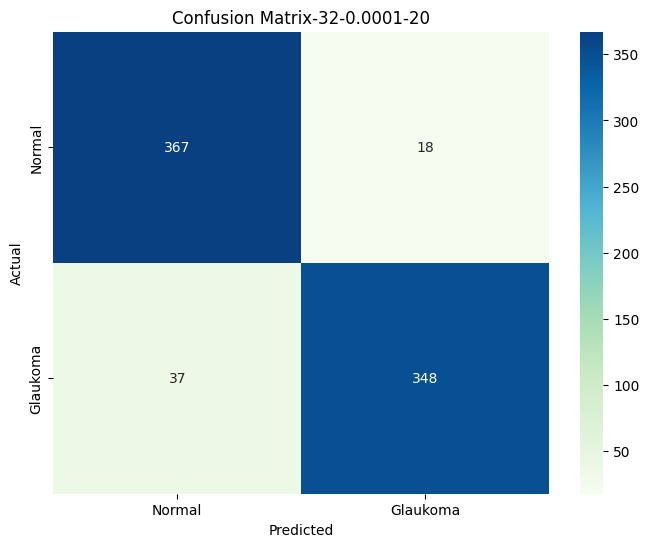

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_true contains the true labels of your test set
# Replace it with the actual labels from your test set
y_true = testGen.labels

# Assuming y_pred_prob contains the predicted probabilities from your model
# Replace it with the actual predicted probabilities from your model
y_pred_prob = model.predict(testGen)

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='GnBu', xticklabels=['Normal', 'Glaukoma'], yticklabels=['Normal', 'Glaukoma'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix-{batch_size}-{learning_rate}-{epoch}')
plt.savefig(f'confusion matrix-{batch_size}-{learning_rate}-{epoch}.png')
plt.show()


In [11]:
# Save training history to a pickle file
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
    

model.save(f'model_{batch_size}_{learning_rate}_{epoch}.h5')

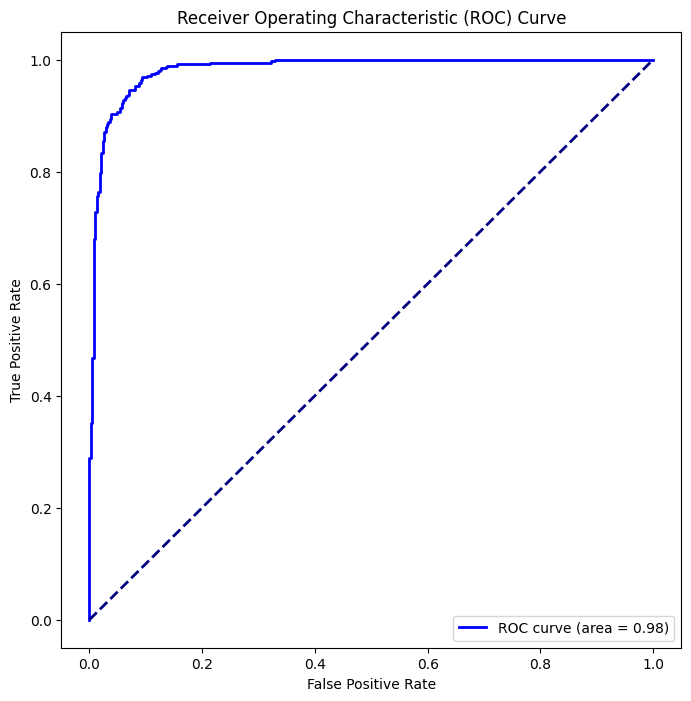

In [12]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(f'ROC-AU Curve_{batch_size}_{learning_rate}_{epoch}.png')
plt.show()